idea: can we use something like a siamese net to tell the difference between the pre and post images?

#### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [5]:
data_dir = Path("/media/wwymak/Storage/xView2")
image_crops_dir_post = data_dir / "classification_crops_post"
image_crops_dir_pre = data_dir / "classification_crops_pre"
models_path = data_dir / "models"

#### Sanity check after running `process_data_classification.py`
- basic idea of the script is to use the polygons from the 'post' image to also crop the 'pre' image...

In [6]:
image_crops_dir_post.ls()[:5]

[PosixPath('/media/wwymak/Storage/xView2/classification_crops_post/400a3600-9543-47e5-a993-dc8e8d632c8d.png'),
 PosixPath('/media/wwymak/Storage/xView2/classification_crops_post/c5628941-0317-460a-b2ae-ea78d34bd042.png'),
 PosixPath('/media/wwymak/Storage/xView2/classification_crops_post/ad029848-f650-4f03-adf0-da0c4d43d02f.png'),
 PosixPath('/media/wwymak/Storage/xView2/classification_crops_post/046695ca-5f20-480c-bcfa-b03a5e64ce73.png'),
 PosixPath('/media/wwymak/Storage/xView2/classification_crops_post/d1ab21b3-3a4d-44a2-979b-0a44edd264ac.png')]

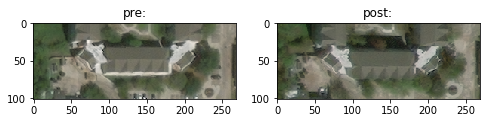

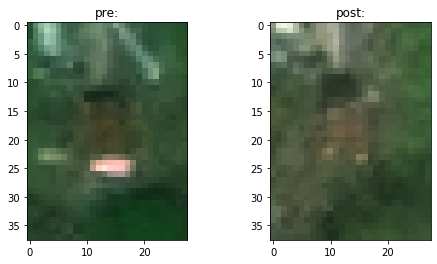

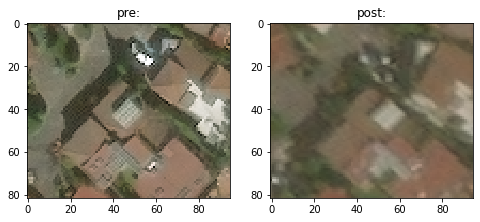

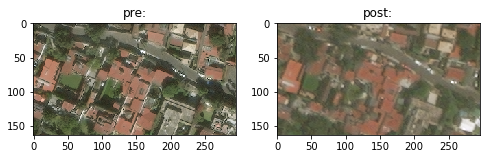

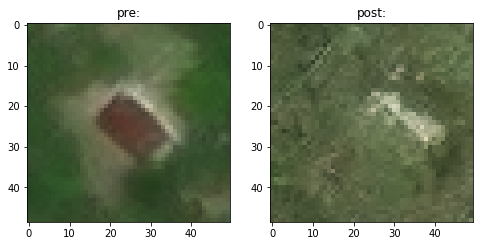

In [7]:
def plot_pre_post(image_fname, add_title=True):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    axs = ax.ravel()
    pre_img = np.array(PIL.Image.open(image_crops_dir_pre/image_fname))
    post_img = np.array(PIL.Image.open(image_crops_dir_post/image_fname))
    axs[0].imshow(pre_img)
    axs[1].imshow(post_img)
    if add_title:
        axs[0].set_title(f'pre:')
        axs[1].set_title(f'post:')
_=[plot_pre_post(x.name) for x in image_crops_dir_post.ls()[:5]]

In [11]:
def get_train_valid_ids(classification_labels_df, img_id_col, valid_pct=0.1, random_seed=42):
    np.random.seed(random_seed)
    unique_img_ids = classification_labels_df[img_id_col].unique()
    np.random.shuffle(unique_img_ids)
    train_img_ids = unique_img_ids[:int(len(unique_img_ids) * (1- valid_pct))]
    valid_img_ids = unique_img_ids[int(len(unique_img_ids) * (1- valid_pct)):]
    
    train_ids = classification_labels_df[classification_labels_df[img_id_col].isin(train_img_ids)].crop_filename.values
    valid_ids = classification_labels_df[classification_labels_df[img_id_col].isin(valid_img_ids)].crop_filename.values
    
    return train_ids, valid_ids

def is_valid_func(img_fname, valid_ids):
    id = Path(img_fname).name
    return id in valid_ids


In [10]:
train_pre_post = pd.read_csv(data_dir/"train_pre_post.csv")
train_pre_post['crop_filename']= train_pre_post.uuid.apply(lambda x: f"{x}.png")
train_pre_post.head()

,uuid,img_id_pre,img_id_post,label,crop_filename
0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,93d0ff06-ab71-45d9-9ace-6f7d86d5d5d8.png
1,437988fc-fb7e-4b0e-8ccf-403015a737b3,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,437988fc-fb7e-4b0e-8ccf-403015a737b3.png
2,63d78637-7c40-40c7-a1b3-55152a64415a,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,63d78637-7c40-40c7-a1b3-55152a64415a.png
3,31ccdff0-b7f7-4884-8e55-d35e4d2c1770,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,31ccdff0-b7f7-4884-8e55-d35e4d2c1770.png
4,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b,palu-tsunami_00000024_pre_disaster.png,palu-tsunami_00000024_post_disaster.png,0,67fdaa2a-3d1f-4c7d-a63b-f08a4a4cb05b.png


In [12]:

train_ids, valid_ids = get_train_valid_ids(train_pre_post, "img_id_pre")
valid_func = partial(is_valid_func,valid_ids=valid_ids)

In [13]:
mean, std = torch.tensor(imagenet_stats)
mean.shape, std.shape, mean, std

(torch.Size([3]),
 torch.Size([3]),
 tensor([0.4850, 0.4560, 0.4060]),
 tensor([0.2290, 0.2240, 0.2250]))

In [23]:
def _resolve_tfms(tfms:TfmList):
    "Resolve every tfm in `tfms`."
    for f in listify(tfms): f.resolve()
        
# class ImageTuple(Image):
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj= (img1,img2)
#         print(img1.data.max(), img2.data.max())
        #normalisation
        self.data = [(img1.data-mean[...,None,None])/std[...,None,None], (img2.data-mean[...,None,None])/std[...,None,None]]
#         self.data = [img1.data, img2.data]
    def apply_tfms(self, tfms, **kwargs):
        # using the do_resolve in this way here is important to make sure the same transform is applied to both images
        self.img1 = self.img1.apply_tfms(tfms, do_resolve=True, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, do_resolve=False, **kwargs)
        self.data = [self.img1.data,self.img2.data]
        return self

    
    def to_one(self): 
        return Image(mean[...,None,None]+torch.cat(self.data,2)*std[...,None,None])
    
class ImageTupleList(ImageList):
    _label_cls=CategoryList
    
    def __init__(self, items, path_pre=None, **kwargs):
        super().__init__(items, **kwargs)
        self.path_pre = path_pre
        self.copy_new.append('path_pre')
        
    def get(self, i):
        img1 = super().get(i)

        img2_filename = Path(self.path_pre)/Path(self.items[i]).name
        return ImageTuple(img1, open_image(img2_filename))
    
    def reconstruct(self, t:Tensor): 
#         return ImageTuple(Image(t[0]*std[...,None,None] +mean[...,None,None]),
#             Image(t[1]*std[...,None,None] +mean[...,None,None]))
        return ImageTuple(Image(t[0]),Image(t[1]))
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()
        
    @classmethod
    def from_df(cls, df, path_pre, path_post, **kwargs):
        res = super().from_df(df, path=path_post, path_pre=path_pre, **kwargs)
#         res.path = path_post
        return res


In [24]:

size=256
bs=8
partial_data_frac=0.2
src = (ImageTupleList
       .from_df(train_pre_post, path_post=image_crops_dir_post, path_pre=image_crops_dir_pre, cols=['crop_filename'])
       .use_partial_data(partial_data_frac)
       .split_by_valid_func(valid_func)
       .label_from_df(cols='label'))
data = (src
        .transform(get_transforms(
            do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75
        ), size=size, tfm_y=False)
        .databunch(bs=bs))

# data = (src.transform((None,None), size=size, tfm_y=False).databunch(bs=bs))


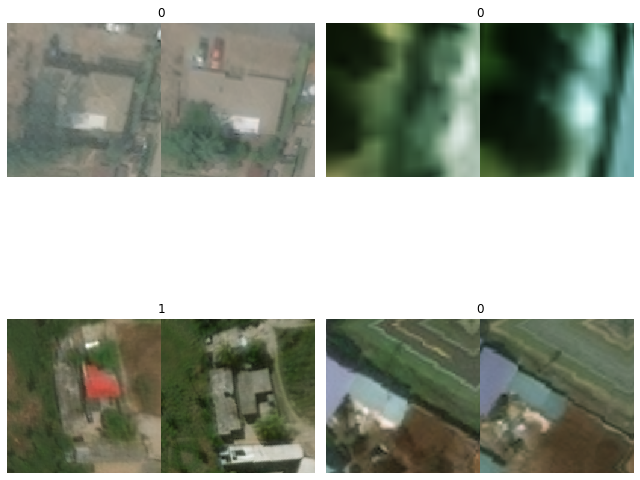

In [25]:
data.show_batch()

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, architecture=models.resnet34, 
                 lin_ftrs=[256, 128], emb_sz=128,ps=0.5, bn_final=False):
        super(SiameseNet, self).__init__()
        self.architecture= architecture
        self.emb_sz = emb_sz
        self.lin_ftrs, self.ps, self.bn_final = lin_ftrs, ps, bn_final
        self.body = cnn_learner.create_body(self.architecture, pretrained=True, 
            learner.cnn_config(self.arch)['cut'])
        self.head = learner.create_head(num_features_model(self.body) * 2, self.emb_sz, self.lin_ftrs, self.ps,self.bn_final)
        self.cnn = nn.Sequential(self.body, self.head)
                                  
    def forward(self, x1, x2):
        output1 = self.cnn(x1)
        output2 = self.cnn(x2)
        return output1, output2

    def get_embedding(self, x):
        return self.cnn(x)

In [29]:
cnn_learner.cnn_config??

Object `cnn_learner.cnn_config` not found.
